In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from termcolor import colored

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Process

In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [4]:
# if not exist, download mnist dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, transform=trans, download=True)
mnist_testset = datasets.MNIST(root='./data', train=False, transform=trans, download=True)

In [5]:
batch_size = 128
N = len(mnist_trainset)
N

60000

In [6]:
N_test = len(mnist_testset)
N_test

10000

In [7]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=N_test,
                shuffle=False)

In [8]:
FF = nn.Flatten()

In [9]:
c = 0
for batch_idx, (example_data, example_targets) in enumerate(train_loader):
    c += 1
    print(example_data.shape)
    print(example_targets.shape)
    print("Flatten", FF(example_data).shape)
    if c ==2:   
        break

torch.Size([128, 1, 28, 28])
torch.Size([128])
Flatten torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128])
Flatten torch.Size([128, 784])


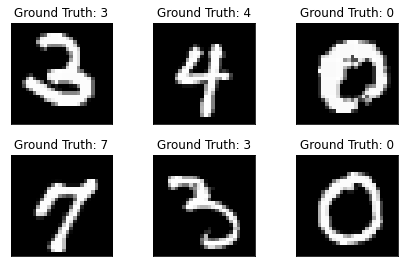

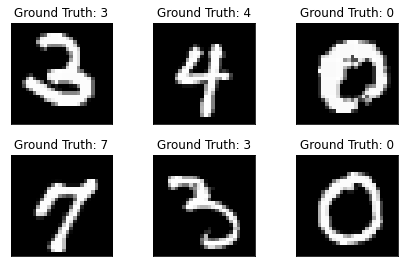

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Main functions

In [11]:
class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super(Gaussian, self).__init__()
        self.norm   = norm(0,1)
        self.mu_    = mu
        self.rho_   = rho
        self.sigma_ = torch.ones(self.mu_.shape).to(device)
        
        
    def sample(self):
        self.eps    = 1*self.norm.sample(self.mu_.shape).type(self.mu_.type()).to(device)
        self.sigma_ = 1*torch.log(1 + torch.exp(self.rho_)).to(device)
        self.W      = self.mu_ + self.sigma_ * self.eps
        return self.W
            
    def loss(self):
        return (0.5*self.mu_**2 + 0.5*self.sigma_ - torch.log(1e-20 + self.sigma_)).sum()

In [12]:
class Blinear(nn.Module):
    def __init__(self, n_input, n_output):
        super(Blinear, self).__init__()
        
        
        self.n_input  = n_input
        self.n_output = n_output
        scale = 1.0/np.sqrt(2*self.n_input)
        
        
        
#         self.mu       = nn.Parameter(scale*torch.randn(n_output, n_input))
#         self.rho      = nn.Parameter(scale * torch.ones(n_output, n_input))
        
#         self.W        = Gaussian(self.mu, self.rho)

#         self.b_mu     = nn.Parameter(torch.zeros(n_output))
#         self.b_rho    = nn.Parameter(scale * torch.ones(n_output))
        
#         self.b        = Gaussian(self.b_mu, self.b_rho)
        
        
        
        self.mu    = nn.Parameter(torch.Tensor(n_output, n_input).normal_(0., .05))  # or .01
        self.rho   = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-3., -3.))
        
        self.W     = Gaussian(self.mu, self.rho)
        
        self.b_mu  = nn.Parameter(torch.Tensor(n_output).normal_(0., .05))
        self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-3., -3.))
        
        self.b     = Gaussian(self.b_mu, self.b_rho)
        
        
        
        
        
    def forward(self, x):
        
        W = self.W.sample()
        b = self.b.sample()
        
        return F.linear(x, W, b)

In [13]:
class BNet(nn.Module):
    
    def __init__(self, layers, act):
        super(BNet, self).__init__()
        
        self.act = act
        self.fc  = nn.ModuleList()
        self.flatten = nn.Flatten()
        for i in range(len(layers) - 1):
            self.fc.append(Blinear(layers[i], layers[i+1]))  
            
            
    def forward(self,x):
        x = self.flatten(x)
        for i in range(len(self.fc) - 1):
            x = self.fc[i].forward(x) #forward based on Blinear 
            x = self.act(x)
            
        x = F.log_softmax(self.fc[-1](x), dim=1)
        
        return x

In [14]:
class BNN():
    def __init__(self, train_loader, layers, act, n_epochs = 10000):
        
        self.train_loader = train_loader
        self.n_layers = len(layers)
        
        self.nepochs = n_epochs
        self.BNet    = BNet(layers, act)
        
    def get_neg_elbo(self):
        neg_elbo = 0
        for i in range(self.n_layers-1):
            neg_elbo += self.BNet.fc[i].W.loss()
            neg_elbo += self.BNet.fc[i].b.loss()
            
        p_pred = self.BNet(self.x)
        
        loss_1 = 0
        for i in range(10):
            loss_1 += p_pred[self.y == i, i].sum()
        loss_1 /= 128
        
#         return neg_elbo + N/batch_size * F.nll_loss(p_pred, self.y, reduction='mean') 
        return neg_elbo - N/batch_size * loss_1
    
    def train(self, lr, decay, step_size = 1000):
    
        optimizer = torch.optim.Adam(self.BNet.parameters(), lr = lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=decay)
        
        for n in range(self.nepochs):
            for batch_idx, (example_data, example_targets) in enumerate(train_loader):
                
                self.x = example_data
                self.y = example_targets
             
                loss = self.get_neg_elbo()
                if batch_idx %10 == 0:
                    print(n, batch_idx)
                    with torch.no_grad():
                        print("Loss = ", loss.item())
                        acc = 0
                        pl = 0
                        for i in range(100):
                            p_pred = self.BNet(self.x).numpy()

#                             pl += sum([np.log(p_pred[self.y == a]) for a in range(10)])/p_pred.shape[0]

                        
                            y_hat = np.argmax(p_pred, axis = 1)
                        
                            acc += (self.y.numpy() == y_hat).astype(int).mean()
                    
                        print(colored('learning rate:{}'.format(optimizer.param_groups[0]['lr']), 'blue'))
                        print(colored('Train accuracy for iteration {} is {}'.format(n, acc/100), 'red'))
#                         print('Predictive log-likelihood for trainat iteration {} is {}'.format(n, pl/100))
                    
                    
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
                scheduler.step()

In [15]:
# l = [10,10]
# lr = 1e-3

In [16]:

for lr in [1e-3, 1e-4, 1e-5]:
    print('---------------------------------------------------------------------')
    print('---------------------------------------------------------------------')
    #print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
    print('---------------------------------------------------------------------')
    print('---------------------------------------------------------------------')
    model = BNN(train_loader, [784, 800, 800, 10], act = nn.ReLU(), n_epochs = 2)
    model.train(lr = 1e-3, decay = 0.9)
    #models.append(model)
    print('---------------------------------------------------------------------')
    print('---------------------------------------------------------------------')
    
    for _, (example_data, example_targets) in enumerate(test_loader):
        A = example_data
        b = example_targets
    z = model.BNet(A).detach()
    T_pred = torch.argmax(z, dim = 1)
    print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  641988.0
learning rate:0.001
Train accuracy for iteration 0 is 0.09640625
0 10
Loss =  3888907.5
learning rate:0.001
Train accuracy for iteration 0 is 0.21234375
0 20
Loss =  3877616.75
learning rate:0.001
Train accuracy for iteration 0 is 0.17234375
0 30
Loss =  3865684.75
learning rate:0.001
Train accuracy for iteration 0 is 0.2725
0 40
Loss =  3854036.5
learning rate:0.001
Train accuracy for iteration 0 is 0.364375
0 50
Loss =  3842904.0
learning rate:0.001
Train accuracy for iteration 0 is 0.344375
0 60
Loss =  3831450.25
learning rate:0.001
Train accuracy for iteration 0 is 0.4984375
0 70
Loss =  3819730.5
learning rate:0.001
Train accuracy for iteration 0 is 0.46703125
0 80
Loss =  3808518.25


learning rate:0.000531441
Train accuracy for iteration 1 is 0.831875
1 220
Loss =  3318885.5
learning rate:0.000531441
Train accuracy for iteration 1 is 0.790625
1 230
Loss =  3313069.0
learning rate:0.000531441
Train accuracy for iteration 1 is 0.795
1 240
Loss =  3307681.75
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.797734375
1 250
Loss =  3302313.5
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.838828125
1 260
Loss =  3297190.5
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.816640625
1 270
Loss =  3291921.5
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.81640625
1 280
Loss =  3286630.0
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.845859375
1 290
Loss =  3281265.0
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.84890625
1 300
Loss =  3276248.25
learning rate:0.0004782969
Train accuracy for iteration 1 is 0.719453125
1 310
Loss =  3270876.25
learning rate:0.0004782969
Train accuracy fo

0 420
Loss =  3496130.75
learning rate:0.0006561000000000001
Train accuracy for iteration 0 is 0.814453125
0 430
Loss =  3488908.0
learning rate:0.0006561000000000001
Train accuracy for iteration 0 is 0.77984375
0 440
Loss =  3481439.0
learning rate:0.0006561000000000001
Train accuracy for iteration 0 is 0.82375
0 450
Loss =  3474257.75
learning rate:0.0006561000000000001
Train accuracy for iteration 0 is 0.799375
0 460
Loss =  3466988.25
learning rate:0.0006561000000000001
Train accuracy for iteration 0 is 0.767578125
1 0
Loss =  3460287.25
learning rate:0.0006561000000000001
Train accuracy for iteration 1 is 0.816875
1 10
Loss =  3452981.0
learning rate:0.0006561000000000001
Train accuracy for iteration 1 is 0.83625
1 20
Loss =  3445925.25
learning rate:0.0006561000000000001
Train accuracy for iteration 1 is 0.811171875
1 30
Loss =  3438479.0
learning rate:0.0006561000000000001
Train accuracy for iteration 1 is 0.784921875
1 40
Loss =  3431796.5
learning rate:0.00059049
Train accurac

0 160
Loss =  3724856.25
learning rate:0.0009000000000000001
Train accuracy for iteration 0 is 0.679375
0 170
Loss =  3714560.25
learning rate:0.0009000000000000001
Train accuracy for iteration 0 is 0.721328125
0 180
Loss =  3704439.75
learning rate:0.0009000000000000001
Train accuracy for iteration 0 is 0.73765625
0 190
Loss =  3694346.0
learning rate:0.0009000000000000001
Train accuracy for iteration 0 is 0.697265625
0 200
Loss =  3683954.0
learning rate:0.0008100000000000001
Train accuracy for iteration 0 is 0.76796875
0 210
Loss =  3674789.25
learning rate:0.0008100000000000001
Train accuracy for iteration 0 is 0.752265625
0 220
Loss =  3665604.25
learning rate:0.0008100000000000001
Train accuracy for iteration 0 is 0.773359375
0 230
Loss =  3656364.5
learning rate:0.0008100000000000001
Train accuracy for iteration 0 is 0.78796875
0 240
Loss =  3647222.75
learning rate:0.0008100000000000001
Train accuracy for iteration 0 is 0.782734375
0 250
Loss =  3638317.5
learning rate:0.000810

1 400
Loss =  3227979.5
learning rate:0.00043046721
Train accuracy for iteration 1 is 0.766328125
1 410
Loss =  3223307.5
learning rate:0.00043046721
Train accuracy for iteration 1 is 0.790078125
1 420
Loss =  3218537.0
learning rate:0.00043046721
Train accuracy for iteration 1 is 0.865234375
1 430
Loss =  3213826.75
learning rate:0.00043046721
Train accuracy for iteration 1 is 0.875546875
1 440
Loss =  3209487.25
learning rate:0.000387420489
Train accuracy for iteration 1 is 0.83109375
1 450
Loss =  3205450.0
learning rate:0.000387420489
Train accuracy for iteration 1 is 0.78359375
1 460
Loss =  3201015.25
learning rate:0.000387420489
Train accuracy for iteration 1 is 0.796640625
---------------------------------------------------------------------
---------------------------------------------------------------------
tensor(0.7955)


In [27]:

torch.clamp(torch.tensor([3,2,-1,6]), max = 3)

tensor([ 3,  2, -1,  3])